<a href="https://colab.research.google.com/github/indhu68/Intro_to_DL_Project/blob/main/RTML_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.nn as nn
import matplotlib.pyplot as plt


In [2]:
# Load data

data = pd.read_csv('https://raw.githubusercontent.com/indhu68/Intro_to_DL_Project/main/Kasungu_Telemetry_Pts_Oct23.csv', parse_dates=['Time.Stamp'])
data = data[["Index","Tag", "Latitude", "Longitude", "Time.Stamp"]]
data['Time.Stamp'] = pd.to_datetime(data['Time.Stamp'])
data.sort_values(by=['Tag', 'Time.Stamp'], inplace=True)

In [3]:
# Calculate speed and distances
epsilon = 1e-5  # Small constant to avoid division by zero
data['Time_diff'] = data.groupby('Tag')['Time.Stamp'].diff().dt.total_seconds().fillna(0)
data['Lat_diff'] = data.groupby('Tag')['Latitude'].diff().fillna(0)
data['Lon_diff'] = data.groupby('Tag')['Longitude'].diff().fillna(0)
data['Speed'] = np.sqrt(data['Lat_diff']**2 + data['Lon_diff']**2) / (data['Time_diff'] + epsilon)

In [4]:
# Handle potential infinite or NaN values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(data.mean(), inplace=True)  # Fill NaNs with the mean of the column


In [5]:
# Normalize features
scaler = MinMaxScaler()
data[['Latitude', 'Longitude', 'Lat_diff', 'Lon_diff', 'Speed']] = scaler.fit_transform(
    data[['Latitude', 'Longitude', 'Lat_diff', 'Lon_diff', 'Speed']]
)

In [6]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps + 1
        if end_ix > len(data):
            break
        seq_x = data.iloc[i:end_ix-1].to_numpy()
        seq_y = data.iloc[end_ix-1][['Latitude', 'Longitude']].to_numpy()
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Prepare sequences
grouped = data.groupby('Tag')
X, y = [], []
for _, group in grouped:
    sequences = create_sequences(group[['Latitude', 'Longitude', 'Lat_diff', 'Lon_diff', 'Speed']], n_steps=5)
    X.append(sequences[0])
    y.append(sequences[1])

X = np.concatenate(X)
y = np.concatenate(y)


In [7]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [9]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(5,32)
        self.lstm = nn.LSTM(input_size=32, hidden_size=128, num_layers=3, batch_first=True)
        self.fc = nn.Linear(128, 2)

    def forward(self, x):
        x = self.fc1(x)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

model = LSTMModel().to('cuda')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
# Prepare data loaders
from torch.utils.data import DataLoader, TensorDataset
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=True)

In [11]:

def train(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to('cuda')
            y_batch = y_batch.to('cuda')
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}')

# Prepare data loaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=True)

# Train the model
train(model, train_loader, criterion, optimizer)


Epoch 1, Loss: 0.0007912141111794672
Epoch 2, Loss: 2.5395743895865778e-05
Epoch 3, Loss: 1.9803334269354418e-05
Epoch 4, Loss: 1.7360332705081658e-05
Epoch 5, Loss: 1.5375103593761198e-05
Epoch 6, Loss: 1.4579710808357847e-05
Epoch 7, Loss: 1.3541012193516084e-05
Epoch 8, Loss: 1.3177556323283208e-05
Epoch 9, Loss: 1.2885541764452591e-05
Epoch 10, Loss: 1.2439723759068484e-05


Actual: [-12.796962  33.169067], Predicted: [-12.798494  33.169205]
Actual: [-12.967528  33.341316], Predicted: [-12.968618  33.34188 ]
Actual: [-12.875618  33.31312 ], Predicted: [-12.877884  33.31539 ]
Actual: [-13.036968  33.22338 ], Predicted: [-13.040738  33.218765]
Actual: [-12.883457  33.22119 ], Predicted: [-12.884335  33.219707]
Actual: [-13.251983  32.97946 ], Predicted: [-13.249391  32.97701 ]
Actual: [-12.892188  33.255554], Predicted: [-12.894614  33.246685]
Actual: [-12.861442  33.213974], Predicted: [-12.862561  33.2154  ]
Actual: [-12.88203   33.238537], Predicted: [-12.882037  33.24283 ]
Actual: [-13.053487  33.269005], Predicted: [-13.0564375  33.269817 ]


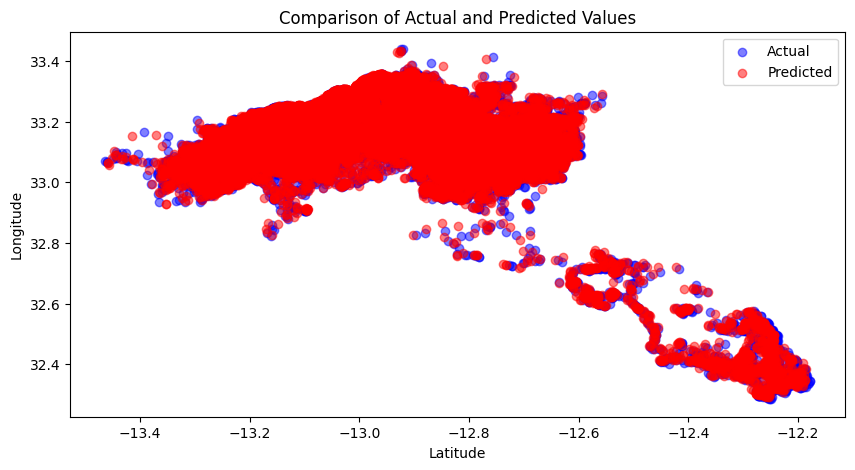


Average Loss: 8.574024034919355e-06


In [26]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def evaluate_and_plot(model, dataloader, criterion, scaler):
    model.eval()
    total_loss = 0
    actuals_list = []
    predicteds_list = []
    sample_count = 0

    min_lat_lon = scaler.data_min_[:2]  # Assuming these are lat and lon
    range_lat_lon = scaler.data_range_[:2]  # Assuming these are lat and lon ranges

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to('cuda')
            y_batch = y_batch.to('cuda')
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()

            actuals = y_batch.cpu().numpy()
            predicteds = predictions.cpu().numpy()

            # Apply inverse scaling to latitude and longitude
            actuals[:, 0:2] = actuals[:, 0:2] * range_lat_lon + min_lat_lon
            predicteds[:, 0:2] = predicteds[:, 0:2] * range_lat_lon + min_lat_lon

            for actual, predicted in zip(actuals, predicteds):
                actuals_list.append(actual[:2])
                predicteds_list.append(predicted[:2])
                if sample_count < 10:
                    print(f'Actual: {actual[:2]}, Predicted: {predicted[:2]}')
                    sample_count += 1

    # Plotting
    actuals_array = np.array(actuals_list)
    predicteds_array = np.array(predicteds_list)
    plt.figure(figsize=(10, 5))
    plt.scatter(actuals_array[:, 0], actuals_array[:, 1], c='blue', label='Actual', alpha=0.5)
    plt.scatter(predicteds_array[:, 0], predicteds_array[:, 1], c='red', label='Predicted', alpha=0.5)
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Comparison of Actual and Predicted Values')
    plt.legend()
    plt.show()

    print(f'\nAverage Loss: {total_loss / len(dataloader)}')

# Assuming you have already defined 'model', 'test_loader', 'criterion', and 'scaler':
evaluate_and_plot(model, test_loader, criterion, scaler)


In [14]:
import torch
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(5, 32)
        self.rnn = nn.RNN(input_size=32, hidden_size=128, num_layers=3, batch_first=True)
        self.fc = nn.Linear(128, 2)

    def forward(self, x):
        x = self.fc1(x)
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

rnn_model = RNNModel().to('cuda')
criterion_rnn = nn.MSELoss()
optimizer_rnn = torch.optim.Adam(rnn_model.parameters(), lr=0.001)


In [16]:

def train(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to('cuda')
            y_batch = y_batch.to('cuda')
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}')

# Prepare data loaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=True)

# Train the model
train(model, train_loader, criterion, optimizer)




Epoch 1, Loss: 1.0397343869313592e-05
Epoch 2, Loss: 1.0326715467344159e-05
Epoch 3, Loss: 1.0313110918807723e-05
Epoch 4, Loss: 1.0217532660889936e-05
Epoch 5, Loss: 1.0113994587039063e-05
Epoch 6, Loss: 1.0055014537845111e-05
Epoch 7, Loss: 1.0025053697532125e-05
Epoch 8, Loss: 1.0003591006619068e-05
Epoch 9, Loss: 9.969816263541741e-06
Epoch 10, Loss: 9.936153184118159e-06


Actual: [-12.832107  33.107624], Predicted: [-12.832963  33.106785]
Actual: [-13.082002  33.04574 ], Predicted: [-13.081744  33.04814 ]
Actual: [-13.046523  33.25722 ], Predicted: [-13.046687  33.25771 ]
Actual: [-12.99419   33.334698], Predicted: [-12.994817  33.3352  ]
Actual: [-12.987545  33.3205  ], Predicted: [-12.978385  33.338844]
Actual: [-12.765645  33.090385], Predicted: [-12.767012  33.09021 ]
Actual: [-13.037485  33.161972], Predicted: [-13.037632  33.16297 ]
Actual: [-13.013565  33.19609 ], Predicted: [-13.010481  33.19325 ]
Actual: [-12.888737  33.19938 ], Predicted: [-12.8906   33.20394]
Actual: [-13.210293  33.09542 ], Predicted: [-13.217333  33.091183]


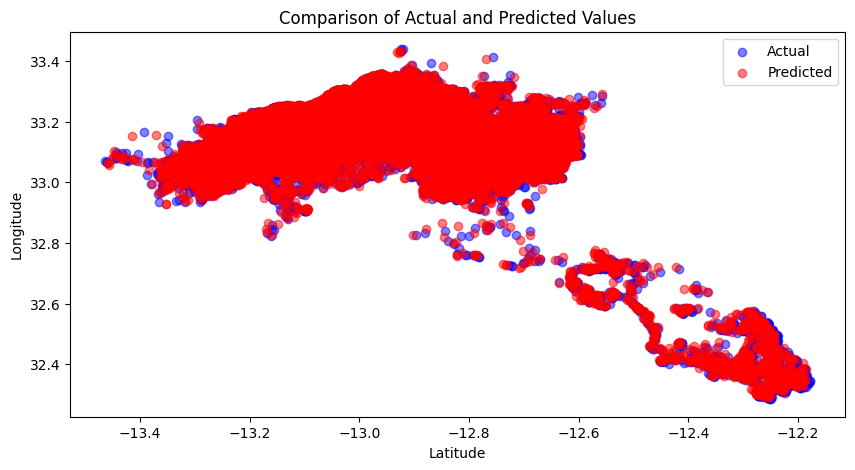


Average Loss: 8.575185256973727e-06


In [27]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def evaluate_and_plot(model, dataloader, criterion, scaler):
    model.eval()
    total_loss = 0
    actuals_list = []
    predicteds_list = []
    sample_count = 0

    min_lat_lon = scaler.data_min_[:2]  # Assuming these are lat and lon
    range_lat_lon = scaler.data_range_[:2]  # Assuming these are lat and lon ranges

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to('cuda')
            y_batch = y_batch.to('cuda')
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()

            actuals = y_batch.cpu().numpy()
            predicteds = predictions.cpu().numpy()

            # Apply inverse scaling to latitude and longitude
            actuals[:, 0:2] = actuals[:, 0:2] * range_lat_lon + min_lat_lon
            predicteds[:, 0:2] = predicteds[:, 0:2] * range_lat_lon + min_lat_lon

            for actual, predicted in zip(actuals, predicteds):
                actuals_list.append(actual[:2])
                predicteds_list.append(predicted[:2])
                if sample_count < 10:
                    print(f'Actual: {actual[:2]}, Predicted: {predicted[:2]}')
                    sample_count += 1

    # Plotting
    actuals_array = np.array(actuals_list)
    predicteds_array = np.array(predicteds_list)
    plt.figure(figsize=(10, 5))
    plt.scatter(actuals_array[:, 0], actuals_array[:, 1], c='blue', label='Actual', alpha=0.5)
    plt.scatter(predicteds_array[:, 0], predicteds_array[:, 1], c='red', label='Predicted', alpha=0.5)
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Comparison of Actual and Predicted Values')
    plt.legend()
    plt.show()

    print(f'\nAverage Loss: {total_loss / len(dataloader)}')

# Assuming you have already defined 'model', 'test_loader', 'criterion', and 'scaler':
evaluate_and_plot(model, test_loader, criterion, scaler)


In [18]:
class GRUModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(5, 32)
        self.gru = nn.GRU(input_size=32, hidden_size=128, num_layers=3, batch_first=True)
        self.fc = nn.Linear(128, 2)

    def forward(self, x):
        x = self.fc1(x)
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

gru_model = GRUModel().to('cuda')
criterion_gru = nn.MSELoss()
optimizer_gru = torch.optim.Adam(gru_model.parameters(), lr=0.001)


In [19]:

def train(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to('cuda')
            y_batch = y_batch.to('cuda')
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}')

# Prepare data loaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=True)

# Train the model
train(model, train_loader, criterion, optimizer)



Epoch 1, Loss: 9.885533056138883e-06
Epoch 2, Loss: 9.987743456577838e-06
Epoch 3, Loss: 9.830288158335676e-06
Epoch 4, Loss: 9.915423344067564e-06
Epoch 5, Loss: 9.827278457642101e-06
Epoch 6, Loss: 9.7230846728799e-06
Epoch 7, Loss: 9.818640588804798e-06
Epoch 8, Loss: 9.723774378364372e-06
Epoch 9, Loss: 9.659902048588797e-06
Epoch 10, Loss: 9.678963574313023e-06


Actual: [-13.029838  33.259686], Predicted: [-13.029707  33.260143]
Actual: [-12.882365  33.254505], Predicted: [-12.881514  33.252483]
Actual: [-13.197608  33.22574 ], Predicted: [-13.200672  33.22311 ]
Actual: [-13.054957  33.104702], Predicted: [-13.055474  33.106068]
Actual: [-12.841908  33.191723], Predicted: [-12.84536   33.192085]
Actual: [-12.862627  33.24444 ], Predicted: [-12.865063  33.24481 ]
Actual: [-12.873935  33.244656], Predicted: [-12.875181  33.24533 ]
Actual: [-12.901862  33.190853], Predicted: [-12.904958  33.18875 ]
Actual: [-13.035668  33.27714 ], Predicted: [-13.037991  33.27647 ]
Actual: [-13.020912  33.27237 ], Predicted: [-13.020683  33.272293]


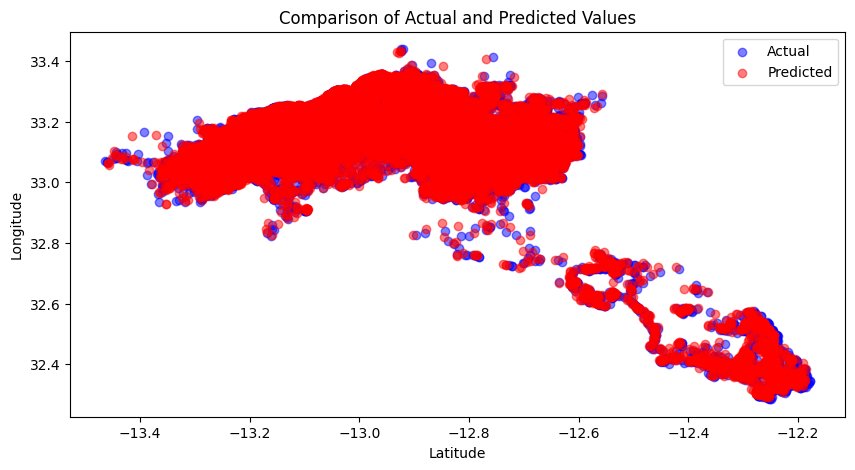


Average Loss: 8.577487728669996e-06


In [28]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def evaluate_and_plot(model, dataloader, criterion, scaler):
    model.eval()
    total_loss = 0
    actuals_list = []
    predicteds_list = []
    sample_count = 0

    min_lat_lon = scaler.data_min_[:2]  # Assuming these are lat and lon
    range_lat_lon = scaler.data_range_[:2]  # Assuming these are lat and lon ranges

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to('cuda')
            y_batch = y_batch.to('cuda')
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()

            actuals = y_batch.cpu().numpy()
            predicteds = predictions.cpu().numpy()

            # Apply inverse scaling to latitude and longitude
            actuals[:, 0:2] = actuals[:, 0:2] * range_lat_lon + min_lat_lon
            predicteds[:, 0:2] = predicteds[:, 0:2] * range_lat_lon + min_lat_lon

            for actual, predicted in zip(actuals, predicteds):
                actuals_list.append(actual[:2])
                predicteds_list.append(predicted[:2])
                if sample_count < 10:
                    print(f'Actual: {actual[:2]}, Predicted: {predicted[:2]}')
                    sample_count += 1

    # Plotting
    actuals_array = np.array(actuals_list)
    predicteds_array = np.array(predicteds_list)
    plt.figure(figsize=(10, 5))
    plt.scatter(actuals_array[:, 0], actuals_array[:, 1], c='blue', label='Actual', alpha=0.5)
    plt.scatter(predicteds_array[:, 0], predicteds_array[:, 1], c='red', label='Predicted', alpha=0.5)
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Comparison of Actual and Predicted Values')
    plt.legend()
    plt.show()

    print(f'\nAverage Loss: {total_loss / len(dataloader)}')

# Assuming you have already defined 'model', 'test_loader', 'criterion', and 'scaler':
evaluate_and_plot(model, test_loader, criterion, scaler)


In [21]:
import torch
import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=num_heads, dim_feedforward=hidden_dim * 4, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        return self.fc_out(x[:, -1, :])

# Example initialization and setting up optimizer and loss
transformer_attention_model = TransformerModel(input_dim=5, num_heads=4, num_layers=3, hidden_dim=128, output_dim=2).to('cuda')
criterion_transformer = nn.MSELoss()
optimizer_transformer = torch.optim.Adam(transformer_attention_model.parameters(), lr=0.001)


In [22]:

def train(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to('cuda')
            y_batch = y_batch.to('cuda')
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}')

# Prepare data loaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=True)

# Train the model
train(model, train_loader, criterion, optimizer)



Epoch 1, Loss: 9.620678285499857e-06
Epoch 2, Loss: 9.559379725176703e-06
Epoch 3, Loss: 9.544881166290032e-06
Epoch 4, Loss: 9.59409381858708e-06
Epoch 5, Loss: 9.55689977527057e-06
Epoch 6, Loss: 9.540485501401853e-06
Epoch 7, Loss: 9.584064781229655e-06
Epoch 8, Loss: 9.584830845273088e-06
Epoch 9, Loss: 9.456047791330367e-06
Epoch 10, Loss: 9.44257934510419e-06


Actual: [-13.037772  33.29579 ], Predicted: [-13.038481  33.29573 ]
Actual: [-12.932092  33.27505 ], Predicted: [-12.93182  33.27366]
Actual: [-13.065988  33.14588 ], Predicted: [-13.088999  33.157875]
Actual: [-12.672887  33.18812 ], Predicted: [-12.677015  33.187756]
Actual: [-12.862577  33.201633], Predicted: [-12.861782  33.201935]
Actual: [-13.044     33.126904], Predicted: [-13.045022  33.12812 ]
Actual: [-12.732905  33.1815  ], Predicted: [-12.732082  33.18325 ]
Actual: [-12.97531   33.331573], Predicted: [-12.974367  33.333076]
Actual: [-12.88951  33.26228], Predicted: [-12.894437  33.26392 ]
Actual: [-13.188447  33.121616], Predicted: [-13.1884165  33.121967 ]


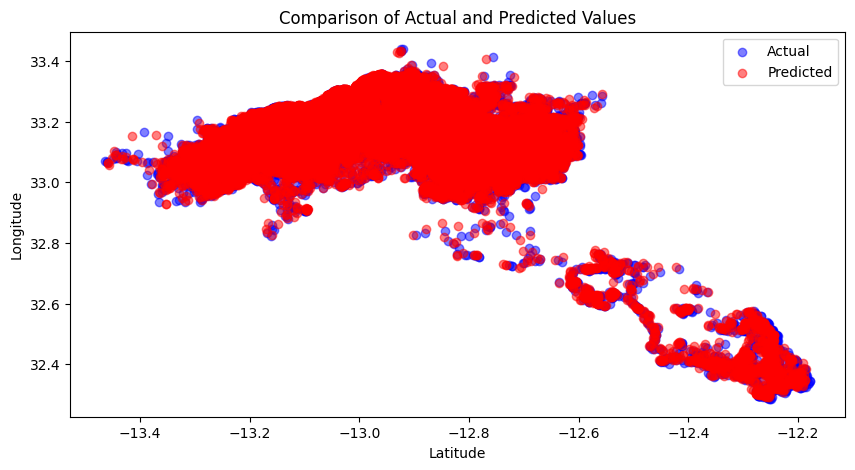


Average Loss: 8.576478616375296e-06


In [29]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def evaluate_and_plot(model, dataloader, criterion, scaler):
    model.eval()
    total_loss = 0
    actuals_list = []
    predicteds_list = []
    sample_count = 0

    min_lat_lon = scaler.data_min_[:2]  # Assuming these are lat and lon
    range_lat_lon = scaler.data_range_[:2]  # Assuming these are lat and lon ranges

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to('cuda')
            y_batch = y_batch.to('cuda')
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()

            actuals = y_batch.cpu().numpy()
            predicteds = predictions.cpu().numpy()

            # Apply inverse scaling to latitude and longitude
            actuals[:, 0:2] = actuals[:, 0:2] * range_lat_lon + min_lat_lon
            predicteds[:, 0:2] = predicteds[:, 0:2] * range_lat_lon + min_lat_lon

            for actual, predicted in zip(actuals, predicteds):
                actuals_list.append(actual[:2])
                predicteds_list.append(predicted[:2])
                if sample_count < 10:
                    print(f'Actual: {actual[:2]}, Predicted: {predicted[:2]}')
                    sample_count += 1

    # Plotting
    actuals_array = np.array(actuals_list)
    predicteds_array = np.array(predicteds_list)
    plt.figure(figsize=(10, 5))
    plt.scatter(actuals_array[:, 0], actuals_array[:, 1], c='blue', label='Actual', alpha=0.5)
    plt.scatter(predicteds_array[:, 0], predicteds_array[:, 1], c='red', label='Predicted', alpha=0.5)
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Comparison of Actual and Predicted Values')
    plt.legend()
    plt.show()

    print(f'\nAverage Loss: {total_loss / len(dataloader)}')

# Assuming you have already defined 'model', 'test_loader', 'criterion', and 'scaler':
evaluate_and_plot(model, test_loader, criterion, scaler)
